In [22]:
import torch as t
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import pandas as pd
import matplotlib.pyplot as plt

from typing import Callable
from tqdm.notebook import tqdm_notebook

In [53]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.1307,), (0.3081,))
])

trainset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
# testset = datasets.MNIST(root="./data", train=False, transform=transform)
# testloader = DataLoader(testset, batch_size=64)

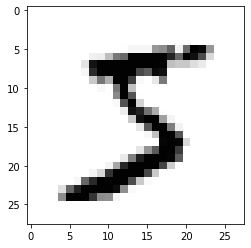

In [54]:
img = trainset[0][0]
plt.imshow(transforms.ToPILImage()(img), cmap='Greys', interpolation="nearest")

In [55]:
class Autoencoder(nn.Module):
    def __init__(self, in_features, encoding_dims=100, latent_dims=5):
        super().__init__()
        self.in_features = in_features
        self.encoder = nn.Sequential(
            nn.Linear(in_features, encoding_dims),
            nn.ReLU(),
            nn.Linear(encoding_dims, latent_dims),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dims, encoding_dims),
            nn.ReLU(),
            nn.Linear(encoding_dims, in_features),
        )

    def forward(self, x: t.Tensor) -> t.Tensor:
        original_shape = x.shape
        batch_size = x.shape[0]
        x = x.view(batch_size, self.in_features)
        x_compressed = self.encoder(x)
        x_reconstructed = self.decoder(x_compressed)
        return x_reconstructed.view(original_shape)

In [56]:
device = 'cuda:0' if t.cuda.is_available() else 'cpu'
device

'cuda:0'

In [57]:
def train_autoencoder(
    model,
    optimizer,
    trainloader: DataLoader,
    epochs: int,
    loss_fn: Callable,
    device: str = device,
) -> list:
    '''
    Defines a ConvNet using our previous code, and trains it on the data in trainloader.
    '''
    model.train()
    loss_list = []

    for epoch in tqdm_notebook(range(epochs)):
        inner_bar = tqdm_notebook(trainloader, leave=False)
        for x, _ in inner_bar:
            # Get batch
            x = x.to(device)

            # Zero grad
            optimizer.zero_grad()

            # Generate output
            x_prime = model(x)

            # Calculate loss
            loss = loss_fn(x_prime, x)

            # Backprop and step
            loss.backward()
            optimizer.step()

            # Metrics
            loss_list.append(loss.item())
            inner_bar.set_description(f'loss={loss.item() :.4f}')

    return loss_list

In [58]:
model = Autoencoder(28 * 28).to(device).train()
opt = t.optim.Adam(model.parameters())

In [59]:
loss_list = train_autoencoder(model, opt, trainloader, 10, nn.MSELoss())

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

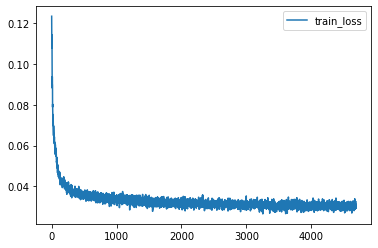

In [60]:
df = pd.DataFrame()
df['train_loss'] = loss_list
df.plot()

In [103]:
# Get samples of each digit eg. imgs[0] has tensor for digit 0
imgs = []
for i in range(10):
    loc_i = (trainset.targets == i).nonzero()[0][0].item()
    imgs.append(trainset[loc_i][0])

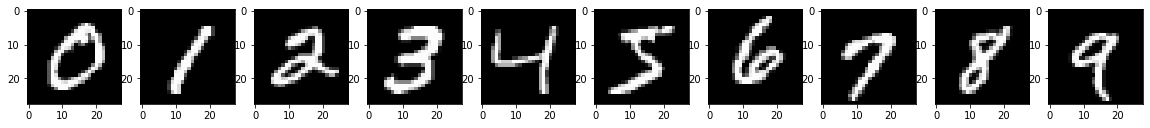

In [111]:
# Plot original images
fig = plt.figure(figsize=(20, 10))

for i in range(10):
    fig.add_subplot(1, 10, i+1)  
    plt.imshow(transforms.ToPILImage()(imgs[i]), cmap='gray')

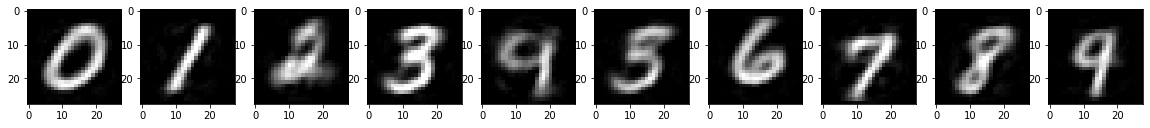

In [112]:
# Plot reconstructed images
fig = plt.figure(figsize=(20, 10))
model.eval()

for i in range(10):
    with t.inference_mode():
        rec = model(imgs[i].view(1, 1, 28, 28).to(device)).view(1, 28, 28)
    fig.add_subplot(1, 10, i+1)  
    plt.imshow(transforms.ToPILImage()(rec.clip(0, 1)), cmap='gray')